In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RidgeCV,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE



## Data preparation
#### Some data cleaning and merging was done using scripts: `get_data.py` and `clean_data.py`
 

In [2]:
#'### Read the data. Filling up missing values with 0
df=pd.read_csv("weather_data/ikermit.csv.gz",compression='gzip')


In [3]:
print(df.columns)
print(df.dtypes)

Index(['TempDry', 'date', 'TempDew', 'TempMeanPast1h', 'TempMaxPast1h',
       'TempMinPast1h', 'Humidity', 'HumidityPast1h', 'Pressure',
       'PressureAtSea', 'WindDir', 'WindDirPast1h', 'WindSpeed',
       'WindSpeedPast1h', 'WindGustAlwaysPast1h', 'WindMax', 'WindMinPast1h',
       'WindMin', 'PrecipPast1h', 'PrecipDurPast1h', 'Visibility', 'Weather',
       'LeavHumDurPast1h'],
      dtype='object')
TempDry                 float64
date                     object
TempDew                 float64
TempMeanPast1h          float64
TempMaxPast1h           float64
TempMinPast1h           float64
Humidity                float64
HumidityPast1h          float64
Pressure                float64
PressureAtSea           float64
WindDir                 float64
WindDirPast1h           float64
WindSpeed               float64
WindSpeedPast1h         float64
WindGustAlwaysPast1h    float64
WindMax                 float64
WindMinPast1h           float64
WindMin                 float64
PrecipPast1h   

In [4]:
#Any of these will work
#df["date"]=pd.to_datetime(df.date)
#df["date"] = [datetime.strptime(dt,'%Y-%m-%dT%H:%M:%S%z') for dt in df.date]
df["date"] = [datetime.fromisoformat(dt[:-1]) for dt in df.date]
#print(df["date"])
#print(df.dtypes)


## Cutting some of the data here
## While training models below I got a memory error. Hence I will drop some of the data
## Additionally, there is a huge gap before Dec 1 2021


In [5]:

print(f"Shape before filtering year 2020: {df.shape}")

#print((df.date.iloc[0]))
#(df.date.iloc[0] > datetime(2020,1,1))
#Selecting only some of the data:
#This one worked
beg_date = datetime(2021,8,1)
end_date = datetime(2021,12,1)

#beg_date = datetime(2021,5,1,0,0)
#end_date = datetime(2021,12,1,0,0)
df = df[(df["date"] > beg_date ) & (df["date"] < end_date)]
print(f"Shape after filtering year 2020: {df.shape}")
#
#df.fillna(df.mean(),inplace=True)
df.fillna(0,inplace=True)

## Checking possible correlations below

Shape before filtering year 2020: (390166, 23)
Shape after filtering year 2020: (17536, 23)


# Since the data is ordered from the latest to the oldes date this might cause
# confusion in the split below. Re-ordering data here

In [6]:
# sanity check: look at some values before
df.head(5)

,TempDry,date,TempDew,TempMeanPast1h,TempMaxPast1h,TempMinPast1h,Humidity,HumidityPast1h,Pressure,PressureAtSea,...,WindSpeedPast1h,WindGustAlwaysPast1h,WindMax,WindMinPast1h,WindMin,PrecipPast1h,PrecipDurPast1h,Visibility,Weather,LeavHumDurPast1h
4308,-2.0,2021-11-30 23:50:00,-3.7,0.0,0.0,0.0,88.0,0.0,998.5,999.8,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4309,-1.8,2021-11-30 23:40:00,-3.5,0.0,0.0,0.0,88.0,0.0,998.7,999.9,...,0.0,0.0,2.2,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4310,-1.8,2021-11-30 23:30:00,-3.5,0.0,0.0,0.0,88.0,0.0,998.8,1000.0,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4311,-1.9,2021-11-30 23:20:00,-3.4,0.0,0.0,0.0,89.0,0.0,998.7,1000.0,...,0.0,0.0,3.1,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4312,-2.0,2021-11-30 23:10:00,-3.5,0.0,0.0,0.0,90.0,0.0,998.7,1000.0,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0


In [7]:
df.sort_values(by=["date"],inplace=True)

In [8]:
df.tail(5)

,TempDry,date,TempDew,TempMeanPast1h,TempMaxPast1h,TempMinPast1h,Humidity,HumidityPast1h,Pressure,PressureAtSea,...,WindSpeedPast1h,WindGustAlwaysPast1h,WindMax,WindMinPast1h,WindMin,PrecipPast1h,PrecipDurPast1h,Visibility,Weather,LeavHumDurPast1h
4312,-2.0,2021-11-30 23:10:00,-3.5,0.0,0.0,0.0,90.0,0.0,998.7,1000.0,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4311,-1.9,2021-11-30 23:20:00,-3.4,0.0,0.0,0.0,89.0,0.0,998.7,1000.0,...,0.0,0.0,3.1,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4310,-1.8,2021-11-30 23:30:00,-3.5,0.0,0.0,0.0,88.0,0.0,998.8,1000.0,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4309,-1.8,2021-11-30 23:40:00,-3.5,0.0,0.0,0.0,88.0,0.0,998.7,999.9,...,0.0,0.0,2.2,0.0,0.0,0.0,0.0,50000.0,0.0,0.0
4308,-2.0,2021-11-30 23:50:00,-3.7,0.0,0.0,0.0,88.0,0.0,998.5,999.8,...,0.0,0.0,2.6,0.0,0.0,0.0,0.0,50000.0,0.0,0.0


In [9]:
## separate some columns
hum_cols = ["Humidity", "HumidityPast1h"]    
temp_cols = ["TempDew","TempMeanPast1h","TempMaxPast1h","TempMinPast1h"]
wind_cols = ["WindSpeed","WindSpeedPast1h", "WindGustAlwaysPast1h", "WindMax","WindMinPast1h","WindMin"]

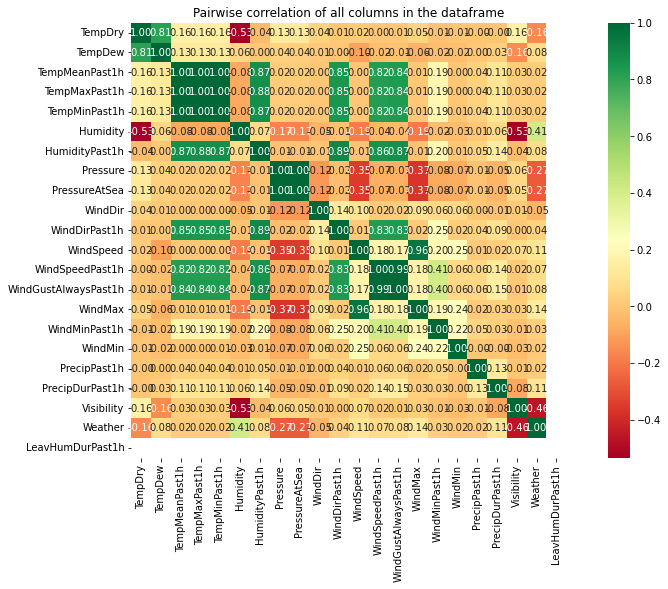

In [10]:
plt.figure(figsize=(15,8))
#sns.heatmap(data= df.corr(), annot=True)
sns.heatmap(data=df.corr(), cbar = True, annot=True, square = True,cmap="RdYlGn", fmt = '.2f')

plt.title("Pairwise correlation of all columns in the dataframe")
# save the figure
#plt.savefig('corr.png', dpi=300, bbox_inches='tight')
plt.show()

### Dropping some variables
WindDir (wind direction) will be ignored and dropped from the list, since it 
it follows circular statistics (it might be confusing to use with other scalar variables)

LeavHumDurPast1h is obviously very empty ("Number of minutes with leaf moisture in the latest 10 minutes"). 
It does not seem relevant.

Weather is an indication of the weather state, and it has a range of values ranging from 0 to 190 or so.


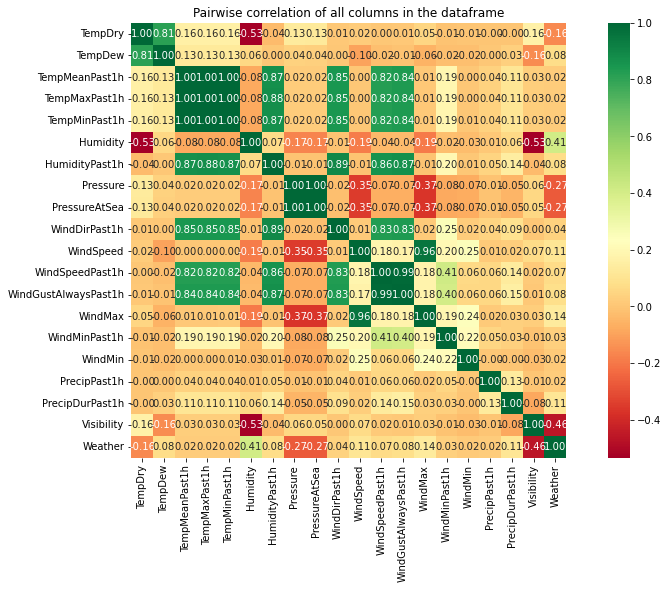

In [11]:
df.drop(columns=["LeavHumDurPast1h"],inplace=True)
df.drop(columns=["WindDir"],inplace=True)
plt.figure(figsize=(15,8))
#sns.heatmap(data= df.corr(), annot=True)
sns.heatmap(data=df.corr(), cbar = True, annot=True, square = True,cmap="RdYlGn", fmt = '.2f')

plt.title("Pairwise correlation of all columns in the dataframe")
# save the figure
#plt.savefig('corr.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Checking for correlation with WindSpeed
all_corrs= df.corrwith(df["WindSpeed"]).abs().sort_values(ascending=False)
temp_corrs = df[temp_cols].corrwith(df["WindSpeed"]).abs().sort_values(ascending=False)
hum_corrs = df[hum_cols].corrwith(df["WindSpeed"]).abs().sort_values(ascending=False)
weather_corrs = df[["Weather"]].corrwith(df["WindSpeed"]).abs().sort_values(ascending=False)
print("All correlations")
print(all_corrs)
print("Correlations with temperature variables")
print(temp_corrs)
print("Correlations with humidity variables")
print(hum_corrs)
print("Correlations for weather")
print(weather_corrs)
#time_corr=df[["time"]].corrwith(df["WindSpeed"])
#print(f"Corr with time {time_corr}")

All correlations
WindSpeed               1.000000
WindMax                 0.956748
PressureAtSea           0.351420
Pressure                0.351294
WindMin                 0.250329
WindMinPast1h           0.197082
Humidity                0.191389
WindSpeedPast1h         0.180679
WindGustAlwaysPast1h    0.168357
Weather                 0.107788
TempDew                 0.097925
Visibility              0.068576
PrecipDurPast1h         0.024827
TempDry                 0.017646
WindDirPast1h           0.014113
HumidityPast1h          0.011983
PrecipPast1h            0.011422
TempMinPast1h           0.004547
TempMeanPast1h          0.003074
TempMaxPast1h           0.001623
dtype: float64
Correlations with temperature variables
TempDew           0.097925
TempMinPast1h     0.004547
TempMeanPast1h    0.003074
TempMaxPast1h     0.001623
dtype: float64
Correlations with humidity variables
Humidity          0.191389
HumidityPast1h    0.011983
dtype: float64
Correlations for weather
Weather    0.1

In [13]:
#sns.histplot(df.Weather, bins=30)

In [14]:
#sns.histplot(df['TempDry'], bins=10)

In [15]:
# Datetime conversion
#from datetime import datetime
#times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in df.date]
#time_stamps = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S').timestamp() for time in df.date]
#df["unixtime"] = time_stamps
#df["time"] = times # [t.timestamp() for t in times]

In [16]:
highest_corr_cols = [col for col in all_corrs[all_corrs > 0.09].index.values if col != "WindSpeed"]
print("Ordering variables with highest correlations")
print(highest_corr_cols)

Ordering variables with highest correlations
['WindMax', 'PressureAtSea', 'Pressure', 'WindMin', 'WindMinPast1h', 'Humidity', 'WindSpeedPast1h', 'WindGustAlwaysPast1h', 'Weather', 'TempDew']


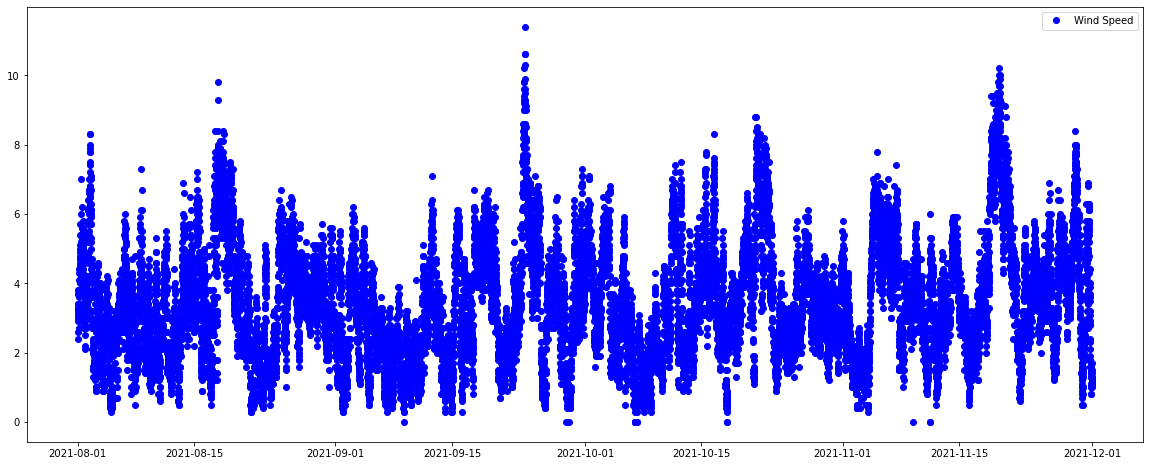

In [17]:
#Having a look at the data
fig = plt.figure(figsize=(20,8))
plt.plot_date(df["date"],df["WindSpeed"],label='Wind Speed',color='b')
plt.legend(loc=1)


In [18]:
#sns.histplot(df.WindSpeed, bins=20)

# Setting up models

In [19]:
# Dropping date column
#df.drop("date",axis=1)

<!-- Determine storm categories

Five	≥ 70 m/s  	≥ 137 kn  	≥ 157 mph  	≥ 252 km/h  
Four	  58–70 m/s  	  113–136 kn  	  130–156 mph  	  209–251 km/h  
Three	  50–58 m/s  	  96–112 kn  	  111–129 mph  	  178–208 km/h  
Two	  43–49 m/s  	  83–95 kn  	  96–110 mph  	  154–177 km/h  
One	 -->

In [20]:
#storm_cats={"one": {"min":33, "max":42},
#            "two": {"min":43, "max":49 }
#             "three"}# in m/s

In [21]:
#import dtale

In [22]:
#dtale.show(df)

### Data split

In [23]:
# Data split. 

df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=4,shuffle=False)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=42, shuffle=False)


In [24]:
print(f"Data for the training covers  period: {df_train.date.iloc[0]} to {df_train.date.iloc[-1]}")

Data for the training covers  period: 2021-08-01 00:10:00 to 2021-10-13 05:30:00


In [25]:
print(f"Data for the validation covers  period: {df_val.date.iloc[0]} to {df_val.date.iloc[-1]}")

Data for the validation covers  period: 2021-10-13 05:40:00 to 2021-11-06 14:10:00


In [26]:
print(f"Data for the testing covers  period: {df_test.date.iloc[0]} to {df_test.date.iloc[-1]}")

Data for the testing covers  period: 2021-11-06 14:20:00 to 2021-11-30 23:50:00


In [27]:

feature_cols = ['WindSpeedPast1h', 'WindMax', 'WindGustAlwaysPast1h', 'WindMin', 'WindMinPast1h', 'TempDew', 'Pressure', 'PressureAtSea', 'WindDirPast1h', 'TempDry', 'Weather', 'TempMeanPast1h', 'TempMaxPast1h', 'TempMinPast1h', 'Humidity', 'HumidityPast1h', 'Visibility']
print(f"Using {len(feature_cols)} features: {feature_cols}")
target_col=["WindSpeed"]


Using 17 features: ['WindSpeedPast1h', 'WindMax', 'WindGustAlwaysPast1h', 'WindMin', 'WindMinPast1h', 'TempDew', 'Pressure', 'PressureAtSea', 'WindDirPast1h', 'TempDry', 'Weather', 'TempMeanPast1h', 'TempMaxPast1h', 'TempMinPast1h', 'Humidity', 'HumidityPast1h', 'Visibility']


In [28]:
X_train = df_train[feature_cols]
y_train = df_train[target_col].values


X_val = df_val[feature_cols]
y_val = df_val[target_col].values

#This to be used at the end!!!
X_test = df_test[feature_cols]
y_test = df_test[target_col].values

print(f"X_train {X_train.shape}")

print(f"X_test {X_test.shape}")
print(f"X_val {X_val.shape}")

X_train (10521, 17)
X_test (3508, 17)
X_val (3507, 17)


### Model setup, using the training data

In [29]:
# Data normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [30]:
#function to calculate error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [31]:
mse = []
r2 = []
rmse_val = []
models = ['LinearRegression','Ridge','Lasso','DecisionTreeRegressor','RandomForestRegressor',"SVR","GradientBoostingRegressor"]




## Linear Regression

lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for linear regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))


score for linear regression on validation data: 0.9063984148295998


In [32]:
## Ridge Regression
rd = Ridge()
rd.fit(X_train,y_train)
y_pred = rd.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Ridge regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))
print(y_pred[0])
print(y_val[0])

score for Ridge regression on validation data: 0.9064312795787005
[2.12510546]
[2.1]


In [33]:
# ## Lasso Regression
ls = Lasso()
ls.fit(X_train,y_train)
y_pred = ls.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Lasso regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))
# r2.append(r2_score(y_val,y_pred))
# rmse_val.append(rmse(y_val,y_pred))

score for Lasso regression on validation data: 0.5069487844320735


In [34]:
## Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
y_pred = ls.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Tree regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))


score for Tree regression on validation data: 0.5069487844320735


In [35]:
# Looks like lin reg works fine in this case

# Test: write model to pickle
import pickle
with open("lin_reg.bin","wb") as f:
    pickle.dump(lm,f)

In [ ]:
# checking predictions
# predicted_wind = regressor.predict(testing)
# predicted_wind= sc.inverse_transform(predicte)
# predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))


# Poor attempt to use RNNs


In [39]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout
from keras.layers import Bidirectional


Define the layers in the RNN. 
1. Create a sequential model by adding layers sequentially using sequential(). 
The first layer is a Bidirectional LSTM (long short term memory) with 30 memory units
return_sequence=True means that the last output in the output sequence is returned 
the input_shape describes the structure of the input. 
With Bidirectional LSTM the output layer gets feedback from past(forward) as well as future(backward) states simultaneously. 
Finally we add 3 hidden layers and an output layer with a linear activation function that outputs 4 days temperature. And at the last, we fit the RNN model with our training data.

In [42]:
n_future = 4 # next 4 days temperature forecast
n_past = 30 # Past 30 d
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (X_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
regressor.fit(X_train, y_train, epochs=500,batch_size=32 )

Epoch 1/500


ValueError: in user code:

    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/media/cap/7fed51bd-a88e-4971-9656-d617655b6312/data/sources/conda/miniconda3/envs/py39/lib/python3.9/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_4" (type Sequential).
    
    Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 17)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 17), dtype=float32)
      • training=True
      • mask=None


In [45]:
y_train.shape

(10521, 1)

In [46]:
X_train.shape

(10521, 17)